# Becoming backprop ninja

## Dataset BS, same as before

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [27]:
# read in all words
words = open("names.txt", "r").read().splitlines()
words[:8]
words[:8]
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [28]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
vocab_size

27

In [29]:
block_size = 3

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)

    return X, Y

In [30]:
import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[:n2])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([205280, 3]) torch.Size([205280])


## Real stuff now

In [31]:
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt-t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [32]:
n_embd = 10
n_hidden = 64

g = torch.Generator().manual_seed(2147483647)

W1_kaiming = (5/3) * 1 / (n_embd*block_size)**0.5

C = torch.randn((vocab_size, n_embd),       generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * W1_kaiming
b1 = torch.randn((1, n_hidden),             generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),    generator=g) * 0.1
b2 = torch.randn((1, vocab_size),           generator=g) * 0.1

bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias] # no b1
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

4137


In [33]:
batch_size = 32
n = batch_size # a shorter variable for convenience
# minibatch construct
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]

In [34]:
# forward pass, smaller steps that are possible to backward one at a time

emb = C[Xb]
embcat = emb.view(emb.shape[0], -1)
# Linear layer 1
hprebn = embcat @ W1 + b1
# BatchNorm
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff ** 2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # n-1 for correction
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss 
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# Pytorch backward pass
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv,
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
          bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
          embcat, emb]:
    t.retain_grad()
loss.backward()
loss 

tensor(3.3501, grad_fn=<NegBackward0>)

In [247]:
# Exercise 1: backprop through the whole thing manually

dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb]= -1.0/n
dprobs = (1./probs) * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
dcounts = counts_sum_inv * dprobs
dcounts_sum = -1*(counts_sum ** -2) * dcounts_sum_inv
dcounts += dcounts_sum * torch.ones_like(counts)
dnorm_logits = counts*dcounts
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
dlogits += F.one_hot(logits.argmax(1), num_classes=27)*dlogit_maxes
# linear layer 2
dh = dlogits @ W2.T 
dW2 = h.T @ dlogits
db2 = dlogits.sum(0, keepdim=True)
# Non-linearity
dhpreact = (1-h**2)*dh
# batchnorm
dbngain = (bnraw*dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact 
dbnbias = dhpreact.sum(0, keepdim=True)

dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = -0.5*(bnvar + 1e-5)**(-1.5)*dbnvar_inv 
dbndiff2 = 1/(n-1)*torch.ones_like(bndiff2)*dbnvar
dbndiff += 2*bndiff * dbndiff2
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0, keepdim=True)
dhprebn += 1/n*torch.ones_like(hprebn)*dbnmeani
# linear layer 1
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0, keepdim=True)
dembcat = dhprebn @ W1.T
demb = dembcat.view(emb.shape)
# dC vectorized
a = F.one_hot(Xb, num_classes=27).float()
dC = (a.transpose(1,2)@demb).sum(0)

# dC_loop
dC_loop = torch.zeros_like(C)
for i in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[i, j]
        dC_loop[ix] += demb[i, j]


cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts) 
cmp('norm_logits', dnorm_logits, norm_logits) 
cmp('logit_maxes', dlogit_maxes, logit_maxes) 
cmp('logits', dlogits, logits) 
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnraw', dbnraw, bnraw)
cmp('bnbias', dbnbias, bnbias)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)
cmp('C loop', dC_loop, C)



logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff:

In [264]:
# fast forward pass, loss calc

# before 
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast-loss).item())

3.350074529647827 diff: 2.384185791015625e-07


In [265]:
# backward pass
dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits)

logits          | exact: False | approximate: True  | maxdiff: 4.6566128730773926e-09


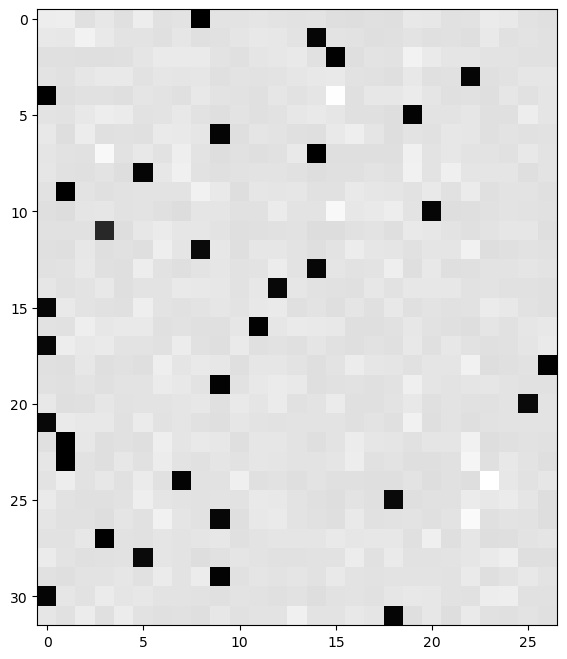

In [260]:
plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(), cmap='gray')

In [272]:
# forward pass batch norm
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff ** 2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # n-1 for correction
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias


hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / (torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5)) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [291]:
# backward pass
dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0, keepdim=True) - n/(n-1)*bnraw*(bnraw * dhpreact).sum(0, keepdim=True))

cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10
